# 0. Funciones y código auxiliar


## 0.1. Instalar las bibliotecas necesarias + Hacer los imports necesarios

In [ ]:
!pip install roboflow torch torchvision opencv-python-headless
!pip install torchmetrics # Para las métricas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 142.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 69.6 MB/s eta 0:00:00


In [ ]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

## 0.2. Clase para leer las imágenes y anotaciones en formato COCO (habiendo importado el dataset de Roboflow) y reformatearlas a lo que necesita Faster R-CNN usando Pytorch

In [ ]:
import os
import torch
import torch.utils.data
from torchvision.io import read_image
from pycocotools.coco import COCO

class RoboflowCocoDataset(torch.utils.data.Dataset):
    """
    Dataset genérico para cargar datos en formato COCO (exportados de Roboflow)
    compatible con torchvision Faster R-CNN.
    """
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        Args:
            root_dir (string): Ruta al directorio que contiene las imágenes (ej. 'train/').
            annotation_file (string): Ruta al archivo .json (ej. '_annotations.coco.json').
            transforms (callable, optional): Transformaciones/Augmentations opcionales.
        """
        self.root = root_dir
        self.coco = COCO(annotation_file)
        # Obtenemos solo IDs de imágenes que tengan anotaciones (opcional, pero recomendado)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        # 1. Obtener metadatos de la imagen y anotaciones
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)

        # 2. Cargar imagen
        path = coco.loadImgs(img_id)[0]['file_name']
        img_path = os.path.join(self.root, path)

        # Leemos la imagen
        img = read_image(img_path)

        # IMPORTANTE: Si la imagen es Grayscale (1 canal), convertir a RGB (3 canales)
        if img.shape[0] == 1:
             img = img.expand(3, -1, -1)

        # 3. Procesar las Bounding Boxes
        num_objs = len(coco_annotation)
        boxes = []
        labels = []

        for i in range(num_objs):
            # COCO es [xmin, ymin, width, height]
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            w = coco_annotation[i]['bbox'][2]
            h = coco_annotation[i]['bbox'][3]

            # PyTorch Faster R-CNN espera [xmin, ymin, xmax, ymax]
            xmax = xmin + w
            ymax = ymin + h

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])

        # 4. Convertir todo a Tensores
        # Si no hay objetos en la imagen, crear tensores vacíos para evitar error
        if num_objs > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)

        image_id = torch.tensor([img_id])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # 5. Normalizar imagen (0-255 -> 0.0-1.0)
        img = img.float() / 255.0

        # Aplicar transformaciones extra si las hubiera
        if self.transforms is not None:
            # Nota: Aplicar transforms a 'target' (cajas) requiere cuidado extra.
            # Aquí asumimos transforms solo a la imagen por simplicidad.
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

## 0.3. Configurar la red para usar el modelo "Faster R-CNN"

Usaremos un modelo pre-entrenado (ResNet50) y modificaremos la cabecera (el clasificador final) para que se ajuste a las clases de cada dataset.

Así mismo, para que no haya conflictos entre los distintos datasets, emplearemos una función que cree un modelo cada vez que vayamos a usar un dataset diferente (una instancia de la red distinta, y así mismo adaptada al número de clases de cada dataset)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_FasterRCNN_model(num_classes):
    # Cargar modelo pre-entrenado en COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Reemplazar el predictor (cabecera) para nuestro número de clases
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

También establecemos el dispositivo donde se ejecutará el entrenamiento y la validación de los modelos (usando GPU si está disponible, o CPU en su defecto).

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 0.4. Función de evaluación de métricas

Definiremos una función que calcula las métricas. Usaremos MeanAveragePrecision con class_metrics=True (contenida en el módulo "torchmetrics") para obtener tanto los valores del resumen global, como también el desglose por clase de las métricas más usuales en Object Detection (en este último caso, solo se empleará "mAP 50-95" por simplicidad), para que después poder comparar con YOLO. A saber:
- mAP (50-95)
- mAP (50)
- mAR (Recall)

In [ ]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm # Para la barra de progreso

def evaluate_model(model, data_loader, device, class_names=None):
    model.eval()
    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluando..."):
            # Mover imágenes al dispositivo
            images = [img.to(device) for img in images]

            # Mover targets al dispositivo (son lista de diccionarios)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Obtener predicciones
            predictions = model(images)

            # Torchmetrics espera lista de dicts
            metric.update(predictions, targets)

    # Calcular métricas finales
    results = metric.compute()

    # Imprimir resumen
    print("\n" + "="*40)
    print(f"Métricas Generales:")
    print(f"mAP (50-95): {results['map']:.4f}")
    print(f"mAP (50):    {results['map_50']:.4f}")
    print(f"mAR (Recall):{results['mar_100']:.4f}") # Recall máx con 100 detecciones

    if class_names and 'map_per_class' in results:
        print("-" * 40)
        print("Desglose por Clase (mAP 50-95):")
        map_per_class = results['map_per_class']
        # mar_per_class = results['mar_100_per_class'] # Si se quiere ver recall por clase

        for i, score in enumerate(map_per_class):
            # i corresponde al índice en el tensor, hay que mapearlo con class_id
            # Ojo: Torchmetrics suele devolver índices 0,1,2... alineados con los labels presentes.
            # Asumiremos orden secuencial de etiquetas detectadas.
            c_name = class_names[i] if i < len(class_names) else f"Class {i}"
            print(f"{c_name:15s}: {score.item():.4f}")

    print("="*40 + "\n")
    return results

## 0.5. Configuración del entrenamiento (común a todos los Datasets)

Se ha seleccionado el optimizador SGD con Momentum (0.9) y Weight Decay (0.0005) siguiendo las especificaciones originales de la arquitectura Faster R-CNN (véase el paper original "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks" https://arxiv.org/abs/1506.01497, concretamente en la sección "Training RPNs").

Aunque el paper de Faster R-CNN (Ren et al., 2015) confirma estos valores, en realidad son "heredados" de su predecesor, Fast R-CNN (Ross Girshick, 2015), y de las prácticas estándar de entrenamiento de redes como VGG y ResNet en ImageNet (véase el paper original "Fast R-CNN" https://arxiv.org/abs/1504.08083, concretamente en la sección "Fine-tuning for detection").

Aunque optimizadores adaptativos como Adam ofrecen una convergencia inicial más rápida, SGD ha demostrado históricamente ofrecer una mayor capacidad de generalización y estabilidad en tareas de Object Detection al realizar fine-tuning sobre redes pre-entrenadas como ResNet (a la vista está que era el estándar de facto empleado en los artículos originales tanto de Faster R-CNN como de Fast R-CNN).

In [ ]:
# Optimizador
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

El número de épocas empleado (25) se tomó en consideración con el empleado también en las diferentes versiones estudiadas de YOLO, para poder hacer la comparación con estas.

In [ ]:
# Número de épocas
num_epochs = 25

Por último, para estas pruebas se empleó la GPU A100 (con 80GB de memoria dedicada) y Alta capacidad de RAM (128GB)

# 1. Dataset ROSAS

https://universe.roboflow.com/germanrv/rose-leaf-diseases-gboa4

## 1.1. Dataset ROSAS (SIN DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/rose-leaf-diseases-gboa4 en su versión "V2_NoDataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v4 (V2_NoDataAug - sin data augmentation)
project = rf.workspace("germanrv").project("rose-leaf-diseases-gboa4")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rose-leaf-diseases-4 in coco:: 100%|██████████| 2733/2733 [00:00<00:00, 5635.36it/s]


Como se verá más adelante para el entrenamiento, cargaremos los datasets de entrenamiento y validación por separado, pues en la implementación considerada no fue posible replicar del todo el flujo de trabajo en Fastai (como en la práctica 2, donde en el dataloader podíamos elegir el porcentaje del dataset de entrenamiento que se emplearía para validar y usando la función "fit" o "fit_one_cycle" para entrenar sobre el dataloader ya preparado), siendo necesario en este caso, en el entrenamiento, separar en cada época la fase de entrenamiento (actualizando pesos) y la fase de validación (evaluando el modelo en el conjunto de validación pero SIN ACTUALIZAR PESOS).

In [ ]:
# Rutas a los datos descargados
train_dir_Rosas = "/content/rose-leaf-diseases-4/train"
train_ann_Rosas = "/content/rose-leaf-diseases-4/train/_annotations.coco.json"
valid_dir_Rosas = "/content/rose-leaf-diseases-4/valid"
valid_ann_Rosas = "/content/rose-leaf-diseases-4/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Rosas = RoboflowCocoDataset(train_dir_Rosas, train_ann_Rosas)
dataset_valid_Rosas = RoboflowCocoDataset(valid_dir_Rosas, valid_ann_Rosas)

train_loader_Rosas = torch.utils.data.DataLoader(
    dataset_train_Rosas,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Rosas = torch.utils.data.DataLoader(
    dataset_valid_Rosas,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Inspeccionamos las clases resultantes en el dataset (pues esta información será necesaria para luego configurar adecuadamente la red).

Como era de esperar, en este formato, se pueden observar las 3 clases que se quieren detectar ("EarlyBlight", "Tomato healthy" y "lateBlight"), así como una cuarta clase ("tomatoes-and-leaves") referente al Background (el fondo).

In [ ]:
# Acceder al objeto COCO interno
coco_Rosas = dataset_train_Rosas.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Rosas = coco_Rosas.getCatIds()
categories_Rosas = coco_Rosas.loadCats(cat_ids_Rosas)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Rosas)}")
print("-" * 30)
for cat in categories_Rosas:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 5
------------------------------
ID: 0 - Nombre: rose-leaf-diseases
ID: 1 - Nombre: Black Spot
ID: 2 - Nombre: Downy Mildew
ID: 3 - Nombre: Normal
ID: 4 - Nombre: Powdery Mildew
------------------------------


Así mismo, verificamos que el número de imagenes coincide con el esperado (el que aparecía en Roboflow)

In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Rosas, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Rosas, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 1656
Imágenes de validación: 534


### 2. Entrenamiento

Antes de proceder al entrenamiento en sí, por seguridad, comprobamos que efectivamente se está haciendo uso de la GPU (para que el entrenamiento no se haga excesivamente largo)

In [ ]:
import torch
print(f"Torh ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torh ve la GPU: True
Nombre: NVIDIA A100-SXM4-80GB


NOTA: Es importante en el paso anterior haber revisado explícitamente el dataset para ver cuántas clases había (num_classes).

Empezamos por instanciar una modelo "Faster R-CNN" adaptado al dataset de las Rosas (teniendo en cuenta el número de clases a detectar, para formar la cabecera correspondiente), así como enviar dicho modelo al dispositivo detectado (GPU o CPU)

In [ ]:
num_classes_Rosas = 5
modelo_Rosas = get_FasterRCNN_model(num_classes_Rosas)
modelo_Rosas.to(device);

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 246MB/s]


Empleamos el optimizador (como ya se comentó anteriormente, común a los diferentes datasets empleados) pero adaptado al modelo instanciado para este dataset

In [ ]:
params_Rosas = [p for p in modelo_Rosas.parameters() if p.requires_grad]
optimizer_Rosas = torch.optim.SGD(params_Rosas, lr=0.005, momentum=0.9, weight_decay=0.0005)

A continuación pasamos a entrenar, guardando el modelo final (con los pesos actualizados tras completar el entrenamiento) y mostrando la función de pérdida.

Nota 1: Como evaluar las métricas mAP es lento, por conveniencia lo haremos solo al final, para no ralentizar en exceso el entrenamiento (que ya de por sí Faster R-CNN suele tardar más que YOLO).

Nota 2: Para poder replicar el flujo de trabajo clásico de Fastai (tal y como ya se hizo en la práctica 2 de esta asignatura), entrenando con un conjunto de entrenamiento y, al final de cada época, calcular la pérdida en el conjunto de validación (sin entrenar sobre él) para ver las dos curvas juntas, fue necesario envolver la fase de evaluación del modelo sobre el conjunto de validación con "torch.no_grad()" (que simplemente congela los gradientes - i.e. no se actualizan - de modo que esas evaluaciones en validación no son consideradas a efectos de aprender sobre esos ejemplos).

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Rosas) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Rosas.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Rosas, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Rosas(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Rosas.zero_grad()
        losses.backward()
        optimizer_Rosas.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Rosas:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Rosas(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Rosas.state_dict(), "best_model_tomatoes.pth")

print("(Rosas) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Rosas) Iniciando entrenamiento...


Época 1/25 [Train]: 100%|██████████| 104/104 [00:49<00:00,  2.10it/s, loss=0.433]


--> Fin Época 1 | Train Loss: 0.4681 | Valid Loss: 0.2998


Época 2/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.19it/s, loss=0.321]


--> Fin Época 2 | Train Loss: 0.2768 | Valid Loss: 0.2590


Época 3/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.19it/s, loss=0.174]


--> Fin Época 3 | Train Loss: 0.2456 | Valid Loss: 0.2495


Época 4/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.19it/s, loss=0.164]


--> Fin Época 4 | Train Loss: 0.2287 | Valid Loss: 0.2515


Época 5/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.307]


--> Fin Época 5 | Train Loss: 0.2177 | Valid Loss: 0.2624


Época 6/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.19it/s, loss=0.237]


--> Fin Época 6 | Train Loss: 0.2085 | Valid Loss: 0.2578


Época 7/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.0863]


--> Fin Época 7 | Train Loss: 0.1961 | Valid Loss: 0.2542


Época 8/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.17it/s, loss=0.13]


--> Fin Época 8 | Train Loss: 0.1874 | Valid Loss: 0.2666


Época 9/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.184]


--> Fin Época 9 | Train Loss: 0.1802 | Valid Loss: 0.2595


Época 10/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.141]


--> Fin Época 10 | Train Loss: 0.1712 | Valid Loss: 0.2720


Época 11/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.115]


--> Fin Época 11 | Train Loss: 0.1627 | Valid Loss: 0.2704


Época 12/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.0928]


--> Fin Época 12 | Train Loss: 0.1557 | Valid Loss: 0.2670


Época 13/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.135]


--> Fin Época 13 | Train Loss: 0.1501 | Valid Loss: 0.2927


Época 14/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.111]


--> Fin Época 14 | Train Loss: 0.1458 | Valid Loss: 0.2716


Época 15/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.17]


--> Fin Época 15 | Train Loss: 0.1439 | Valid Loss: 0.2871


Época 16/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.116]


--> Fin Época 16 | Train Loss: 0.1362 | Valid Loss: 0.2937


Época 17/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.078]


--> Fin Época 17 | Train Loss: 0.1288 | Valid Loss: 0.2879


Época 18/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.102]


--> Fin Época 18 | Train Loss: 0.1244 | Valid Loss: 0.2687


Época 19/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.0848]


--> Fin Época 19 | Train Loss: 0.1260 | Valid Loss: 0.3237


Época 20/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.135]


--> Fin Época 20 | Train Loss: 0.1225 | Valid Loss: 0.2773


Época 21/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.0888]


--> Fin Época 21 | Train Loss: 0.1131 | Valid Loss: 0.2964


Época 22/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.0705]


--> Fin Época 22 | Train Loss: 0.1097 | Valid Loss: 0.2950


Época 23/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.18it/s, loss=0.156]


--> Fin Época 23 | Train Loss: 0.1054 | Valid Loss: 0.2880


Época 24/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.19it/s, loss=0.0987]


--> Fin Época 24 | Train Loss: 0.1047 | Valid Loss: 0.2889


Época 25/25 [Train]: 100%|██████████| 104/104 [00:47<00:00,  2.19it/s, loss=0.0721]


--> Fin Época 25 | Train Loss: 0.0986 | Valid Loss: 0.2867
(Rosas) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Rosas): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Rosas): 1444.57 segundos
	Equivalente a: 24.08 minutos


### 3. Validación (sobre el conjunto de test)

Primero, empezamos por mostrar la evolución de la función de pérdida durante el entrenamiento (para los conjuntos de entrenamiento y validación, respectivamente)

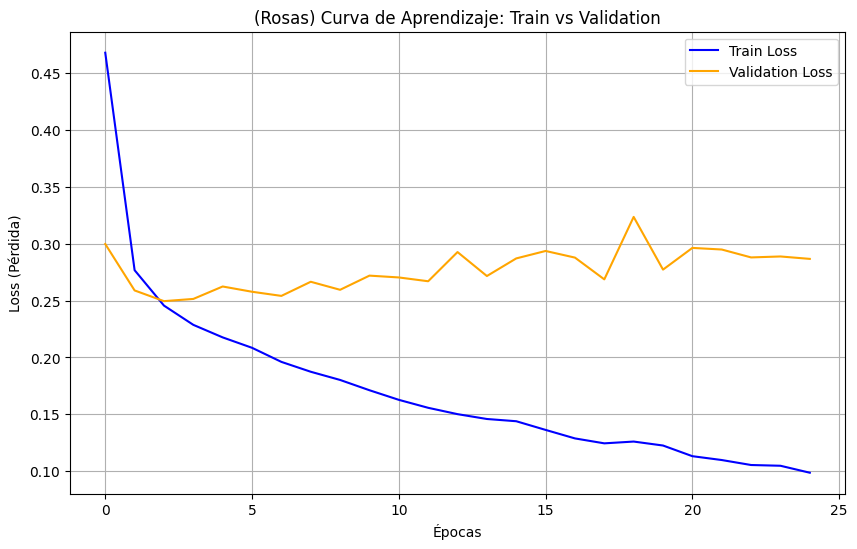

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Rosas) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

A continuación, aplicamos inferencia sobre los conjuntos de entrenamiento y de test (i.e. fuera de la muestra), y calculamos el valor de las métricas en cada uno.

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Rosas = "/content/rose-leaf-diseases-4/test"
test_ann_Rosas = "/content/rose-leaf-diseases-4/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Rosas = RoboflowCocoDataset(test_dir_Rosas, test_ann_Rosas)
test_loader_Rosas = torch.utils.data.DataLoader(
    dataset_test_Rosas,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["Black Spot", "Downy Mildew", "Normal", "Powdery Mildew"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN ---")
metrics_train = evaluate_model(modelo_Rosas, train_loader_Rosas, device, class_names=mis_clases)

print("\n--- TEST ---")
metrics_test = evaluate_model(modelo_Rosas, test_loader_Rosas, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

--- TRAIN ---


Evaluando...: 100%|██████████| 104/104 [00:27<00:00,  3.73it/s]



Métricas Generales:
mAP (50-95): 0.7562
mAP (50):    0.9904
mAR (Recall):0.8157
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.8191
Downy Mildew   : 0.6449
Normal         : 0.7557
Powdery Mildew : 0.8052


--- TEST ---


Evaluando...: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]



Métricas Generales:
mAP (50-95): 0.4839
mAP (50):    0.8580
mAR (Recall):0.5693
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.5835
Downy Mildew   : 0.4965
Normal         : 0.5802
Powdery Mildew : 0.2754



## 1.2. Dataset ROSAS (CON DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/rose-leaf-diseases-gboa4 en su versión "V2_DataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v4 (V2_NoDataAug - sin data augmentation)
project = rf.workspace("germanrv").project("rose-leaf-diseases-gboa4")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rose-leaf-diseases-3 in coco:: 100%|██████████| 6045/6045 [00:01<00:00, 5798.52it/s]


In [ ]:
# Rutas a los datos descargados
train_dir_Rosas_DataAug = "/content/rose-leaf-diseases-3/train"
train_ann_Rosas_DataAug = "/content/rose-leaf-diseases-3/train/_annotations.coco.json"
valid_dir_Rosas_DataAug = "/content/rose-leaf-diseases-3/valid"
valid_ann_Rosas_DataAug = "/content/rose-leaf-diseases-3/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Rosas_DataAug = RoboflowCocoDataset(train_dir_Rosas_DataAug, train_ann_Rosas_DataAug)
dataset_valid_Rosas_DataAug = RoboflowCocoDataset(valid_dir_Rosas_DataAug, valid_ann_Rosas_DataAug)

train_loader_Rosas_DataAug = torch.utils.data.DataLoader(
    dataset_train_Rosas_DataAug,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Rosas_DataAug = torch.utils.data.DataLoader(
    dataset_valid_Rosas_DataAug,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Rosas_DataAug = dataset_train_Rosas_DataAug.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Rosas_DataAug = coco_Rosas_DataAug.getCatIds()
categories_Rosas_DataAug = coco_Rosas_DataAug.loadCats(cat_ids_Rosas_DataAug)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Rosas_DataAug)}")
print("-" * 30)
for cat in categories_Rosas_DataAug:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 5
------------------------------
ID: 0 - Nombre: rose-leaf-diseases
ID: 1 - Nombre: Black Spot
ID: 2 - Nombre: Downy Mildew
ID: 3 - Nombre: Normal
ID: 4 - Nombre: Powdery Mildew
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Rosas_DataAug, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Rosas_DataAug, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 4968
Imágenes de validación: 534


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: NVIDIA A100-SXM4-80GB


In [ ]:
num_classes_Rosas_DataAug = 5
modelo_Rosas_DataAug = get_FasterRCNN_model(num_classes_Rosas_DataAug)
modelo_Rosas_DataAug.to(device);

In [ ]:
params_Rosas_DataAug = [p for p in modelo_Rosas_DataAug.parameters() if p.requires_grad]
optimizer_Rosas_DataAug = torch.optim.SGD(params_Rosas_DataAug, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Rosas CON DataAug) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Rosas_DataAug.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Rosas_DataAug, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Rosas_DataAug(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Rosas_DataAug.zero_grad()
        losses.backward()
        optimizer_Rosas_DataAug.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Rosas_DataAug:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Rosas_DataAug(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Rosas_DataAug.state_dict(), "best_model_tomatoes.pth")

print("(Rosas CON DataAug) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Rosas CON DataAug) Iniciando entrenamiento...


Época 1/25 [Train]: 100%|██████████| 311/311 [02:21<00:00,  2.19it/s, loss=0.388]


--> Fin Época 1 | Train Loss: 0.3330 | Valid Loss: 0.2459


Época 2/25 [Train]: 100%|██████████| 311/311 [02:21<00:00,  2.20it/s, loss=0.337]


--> Fin Época 2 | Train Loss: 0.2498 | Valid Loss: 0.2333


Época 3/25 [Train]: 100%|██████████| 311/311 [02:21<00:00,  2.19it/s, loss=0.39]


--> Fin Época 3 | Train Loss: 0.2347 | Valid Loss: 0.2403


Época 4/25 [Train]: 100%|██████████| 311/311 [02:21<00:00,  2.19it/s, loss=0.199]


--> Fin Época 4 | Train Loss: 0.2213 | Valid Loss: 0.2398


Época 5/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.405]


--> Fin Época 5 | Train Loss: 0.2122 | Valid Loss: 0.2384


Época 6/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.19it/s, loss=0.117]


--> Fin Época 6 | Train Loss: 0.2024 | Valid Loss: 0.2444


Época 7/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.19it/s, loss=0.263]


--> Fin Época 7 | Train Loss: 0.1936 | Valid Loss: 0.2512


Época 8/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.19it/s, loss=0.221]


--> Fin Época 8 | Train Loss: 0.1863 | Valid Loss: 0.2463


Época 9/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.167]


--> Fin Época 9 | Train Loss: 0.1780 | Valid Loss: 0.2571


Época 10/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.176]


--> Fin Época 10 | Train Loss: 0.1721 | Valid Loss: 0.2586


Época 11/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.111]


--> Fin Época 11 | Train Loss: 0.1657 | Valid Loss: 0.2701


Época 12/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.124]


--> Fin Época 12 | Train Loss: 0.1570 | Valid Loss: 0.2798


Época 13/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.242]


--> Fin Época 13 | Train Loss: 0.1497 | Valid Loss: 0.2692


Época 14/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.101]


--> Fin Época 14 | Train Loss: 0.1435 | Valid Loss: 0.2981


Época 15/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.176]


--> Fin Época 15 | Train Loss: 0.1396 | Valid Loss: 0.2734


Época 16/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.147]


--> Fin Época 16 | Train Loss: 0.1332 | Valid Loss: 0.2759


Época 17/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.147]


--> Fin Época 17 | Train Loss: 0.1268 | Valid Loss: 0.2818


Época 18/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.0951]


--> Fin Época 18 | Train Loss: 0.1245 | Valid Loss: 0.2913


Época 19/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.193]


--> Fin Época 19 | Train Loss: 0.1193 | Valid Loss: 0.2828


Época 20/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.211]


--> Fin Época 20 | Train Loss: 0.1175 | Valid Loss: 0.2792


Época 21/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.0762]


--> Fin Época 21 | Train Loss: 0.1143 | Valid Loss: 0.2816


Época 22/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.141]


--> Fin Época 22 | Train Loss: 0.1086 | Valid Loss: 0.2871


Época 23/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.134]


--> Fin Época 23 | Train Loss: 0.1053 | Valid Loss: 0.2883


Época 24/25 [Train]: 100%|██████████| 311/311 [02:22<00:00,  2.18it/s, loss=0.11]


--> Fin Época 24 | Train Loss: 0.1009 | Valid Loss: 0.2980


Época 25/25 [Train]: 100%|██████████| 311/311 [02:23<00:00,  2.17it/s, loss=0.0598]


--> Fin Época 25 | Train Loss: 0.0982 | Valid Loss: 0.2902
(Rosas CON DataAug) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Rosas - CON DataAug): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")
print(f"\tEquivalente a: {total_hours:.2f} horas")

Tiempo Total de Entrenamiento (Rosas - CON DataAug): 3819.00 segundos
	Equivalente a: 63.65 minutos
	Equivalente a: 1.06 horas


### 3. Validación (sobre el conjunto de test)

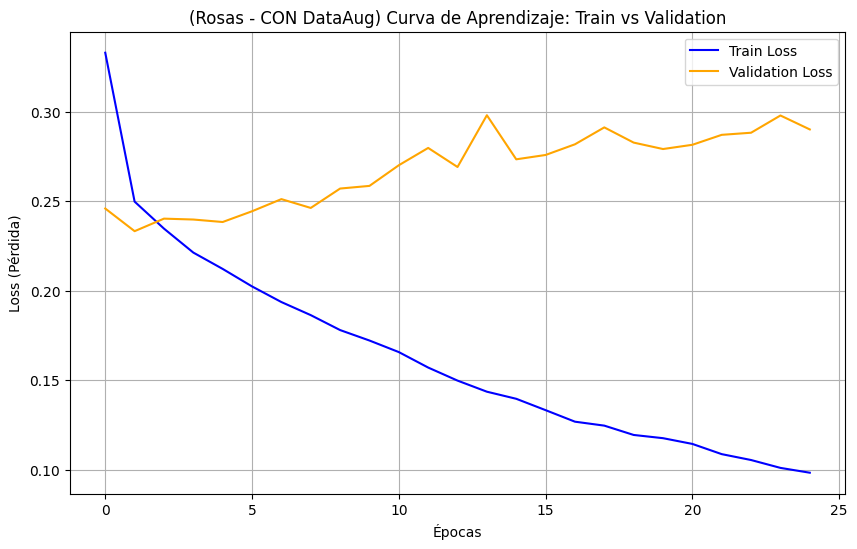

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Rosas - CON DataAug) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Rosas_DataAug = "/content/rose-leaf-diseases-3/test"
test_ann_Rosas_DataAug = "/content/rose-leaf-diseases-3/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Rosas_DataAug = RoboflowCocoDataset(test_dir_Rosas_DataAug, test_ann_Rosas_DataAug)
test_loader_Rosas_DataAug = torch.utils.data.DataLoader(
    dataset_test_Rosas_DataAug,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["Black Spot", "Downy Mildew", "Normal", "Powdery Mildew"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN (Rosas CON DataAug) ---")
metrics_train = evaluate_model(modelo_Rosas_DataAug, train_loader_Rosas_DataAug, device, class_names=mis_clases)

print("\n--- TEST (Rosas CON DataAug) ---")
metrics_test = evaluate_model(modelo_Rosas_DataAug, test_loader_Rosas_DataAug, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

--- TRAIN (Rosas CON DataAug) ---


Evaluando...: 100%|██████████| 311/311 [01:22<00:00,  3.79it/s]



Métricas Generales:
mAP (50-95): 0.7176
mAP (50):    0.9902
mAR (Recall):0.7821
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.8015
Downy Mildew   : 0.6808
Normal         : 0.6680
Powdery Mildew : 0.7201


--- TEST (Rosas CON DataAug) ---


Evaluando...: 100%|██████████| 17/17 [00:09<00:00,  1.83it/s]



Métricas Generales:
mAP (50-95): 0.4591
mAP (50):    0.8357
mAR (Recall):0.5441
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.5621
Downy Mildew   : 0.4430
Normal         : 0.5653
Powdery Mildew : 0.2659



# 2. Dataset PATATAS

https://universe.roboflow.com/germanrv/potatoes_leaf-diseases

## 2.1. Dataset PATATAS (SIN DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/potatoes_leaf-diseases en su versión "V2_NoDataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v4 (V2_NoDataAug - sin data augmentation)
project = rf.workspace("germanrv").project("potatoes_leaf-diseases")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Potatoes_leaf-diseases-4 in coco:: 100%|██████████| 820/820 [00:00<00:00, 5510.54it/s]


In [ ]:
# Rutas a los datos descargados
train_dir_Patatas = "/content/Potatoes_leaf-diseases-4/train"
train_ann_Patatas = "/content/Potatoes_leaf-diseases-4/train/_annotations.coco.json"
valid_dir_Patatas = "/content/Potatoes_leaf-diseases-4/valid"
valid_ann_Patatas = "/content/Potatoes_leaf-diseases-4/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Patatas = RoboflowCocoDataset(train_dir_Patatas, train_ann_Patatas)
dataset_valid_Patatas = RoboflowCocoDataset(valid_dir_Patatas, valid_ann_Patatas)

train_loader_Patatas = torch.utils.data.DataLoader(
    dataset_train_Patatas,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Patatas = torch.utils.data.DataLoader(
    dataset_valid_Patatas,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Patatas = dataset_train_Patatas.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Patatas = coco_Patatas.getCatIds()
categories_Patatas = coco_Patatas.loadCats(cat_ids_Patatas)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Patatas)}")
print("-" * 30)
for cat in categories_Patatas:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 4
------------------------------
ID: 0 - Nombre: potatoes-leaf
ID: 1 - Nombre: early bright
ID: 2 - Nombre: healthy
ID: 3 - Nombre: late bright
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Patatas, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Patatas, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 613
Imágenes de validación: 101


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: NVIDIA A100-SXM4-80GB


In [ ]:
num_classes_Patatas = 4
modelo_Patatas = get_FasterRCNN_model(num_classes_Patatas)
modelo_Patatas.to(device);

In [ ]:
params_Patatas = [p for p in modelo_Patatas.parameters() if p.requires_grad]
optimizer_Patatas = torch.optim.SGD(params_Patatas, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Patatas) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Patatas.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Patatas, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Patatas(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Patatas.zero_grad()
        losses.backward()
        optimizer_Patatas.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Patatas:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Patatas(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Patatas.state_dict(), "best_model_patatas.pth")

print("(Patatas) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Patatas) Iniciando entrenamiento...


Época 1/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.23it/s, loss=0.576]


--> Fin Época 1 | Train Loss: 0.8351 | Valid Loss: 0.3757


Época 2/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.668]


--> Fin Época 2 | Train Loss: 0.5496 | Valid Loss: 0.3454


Época 3/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.685]


--> Fin Época 3 | Train Loss: 0.4913 | Valid Loss: 0.2957


Época 4/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.256]


--> Fin Época 4 | Train Loss: 0.4364 | Valid Loss: 0.2434


Época 5/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.468]


--> Fin Época 5 | Train Loss: 0.4161 | Valid Loss: 0.2427


Época 6/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.331]


--> Fin Época 6 | Train Loss: 0.3925 | Valid Loss: 0.2479


Época 7/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.345]


--> Fin Época 7 | Train Loss: 0.3789 | Valid Loss: 0.2333


Época 8/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.421]


--> Fin Época 8 | Train Loss: 0.3616 | Valid Loss: 0.2511


Época 9/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.301]


--> Fin Época 9 | Train Loss: 0.3439 | Valid Loss: 0.2428


Época 10/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.474]


--> Fin Época 10 | Train Loss: 0.3367 | Valid Loss: 0.2434


Época 11/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.199]


--> Fin Época 11 | Train Loss: 0.3107 | Valid Loss: 0.2475


Época 12/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.23it/s, loss=0.329]


--> Fin Época 12 | Train Loss: 0.3104 | Valid Loss: 0.2587


Época 13/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.267]


--> Fin Época 13 | Train Loss: 0.2964 | Valid Loss: 0.2499


Época 14/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.284]


--> Fin Época 14 | Train Loss: 0.2799 | Valid Loss: 0.2603


Época 15/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.237]


--> Fin Época 15 | Train Loss: 0.2716 | Valid Loss: 0.2650


Época 16/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.465]


--> Fin Época 16 | Train Loss: 0.2594 | Valid Loss: 0.2504


Época 17/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.199]


--> Fin Época 17 | Train Loss: 0.2456 | Valid Loss: 0.2674


Época 18/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.224]


--> Fin Época 18 | Train Loss: 0.2342 | Valid Loss: 0.2724


Época 19/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.0845]


--> Fin Época 19 | Train Loss: 0.2231 | Valid Loss: 0.2691


Época 20/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.20it/s, loss=0.234]


--> Fin Época 20 | Train Loss: 0.2108 | Valid Loss: 0.2764


Época 21/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.238]


--> Fin Época 21 | Train Loss: 0.2025 | Valid Loss: 0.2700


Época 22/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.166]


--> Fin Época 22 | Train Loss: 0.1919 | Valid Loss: 0.2840


Época 23/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.308]


--> Fin Época 23 | Train Loss: 0.1820 | Valid Loss: 0.2885


Época 24/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=0.217]


--> Fin Época 24 | Train Loss: 0.1838 | Valid Loss: 0.2817


Época 25/25 [Train]: 100%|██████████| 39/39 [00:17<00:00,  2.24it/s, loss=0.204]


--> Fin Época 25 | Train Loss: 0.1721 | Valid Loss: 0.3097
(Patatas) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Patatas): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Patatas): 492.51 segundos
	Equivalente a: 8.21 minutos


### 3. Validación (sobre el conjunto de test)

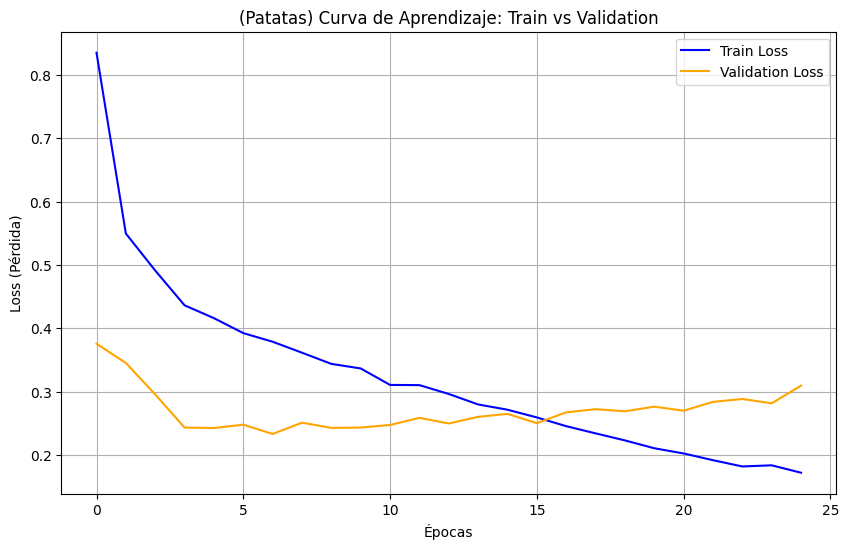

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Patatas) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Patatas = "/content/Potatoes_leaf-diseases-4/test"
test_ann_Patatas = "/content/Potatoes_leaf-diseases-4/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Patatas = RoboflowCocoDataset(test_dir_Patatas, test_ann_Patatas)
test_loader_Patatas = torch.utils.data.DataLoader(
    dataset_test_Patatas,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["early bright", "healthy", "late bright"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN ---")
metrics_train = evaluate_model(modelo_Patatas, train_loader_Patatas, device, class_names=mis_clases)

print("\n--- TEST ---")
metrics_test = evaluate_model(modelo_Patatas, test_loader_Patatas, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

--- TRAIN ---


Evaluando...: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s]



Métricas Generales:
mAP (50-95): 0.7758
mAP (50):    0.9757
mAR (Recall):0.8201
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.7120
healthy        : 0.8600
late bright    : 0.7553


--- TEST ---


Evaluando...: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]



Métricas Generales:
mAP (50-95): 0.4320
mAP (50):    0.6579
mAR (Recall):0.5843
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.2940
healthy        : 0.8637
late bright    : 0.1383



## 2.2. Dataset PATATAS (CON DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/potatoes_leaf-diseases en su versión "v2_AUG"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v3 (v2_AUG - CON data augmentation)
project = rf.workspace("germanrv").project("potatoes_leaf-diseases")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Potatoes_leaf-diseases-3 in coco:: 100%|██████████| 2046/2046 [00:00<00:00, 5803.21it/s]


In [ ]:
# Rutas a los datos descargados
train_dir_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/train"
train_ann_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/train/_annotations.coco.json"
valid_dir_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/valid"
valid_ann_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Patatas_DataAug = RoboflowCocoDataset(train_dir_Patatas_DataAug, train_ann_Patatas_DataAug)
dataset_valid_Patatas_DataAug = RoboflowCocoDataset(valid_dir_Patatas_DataAug, valid_ann_Patatas_DataAug)

train_loader_Patatas_DataAug = torch.utils.data.DataLoader(
    dataset_train_Patatas_DataAug,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Patatas_DataAug = torch.utils.data.DataLoader(
    dataset_valid_Patatas_DataAug,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Patatas_DataAug = dataset_train_Patatas_DataAug.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Patatas_DataAug = coco_Patatas_DataAug.getCatIds()
categories_Patatas_DataAug = coco_Patatas_DataAug.loadCats(cat_ids_Patatas_DataAug)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Patatas_DataAug)}")
print("-" * 30)
for cat in categories_Patatas_DataAug:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 4
------------------------------
ID: 0 - Nombre: potatoes-leaf
ID: 1 - Nombre: early bright
ID: 2 - Nombre: healthy
ID: 3 - Nombre: late bright
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Patatas_DataAug, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Patatas_DataAug, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 1839
Imágenes de validación: 101


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: NVIDIA A100-SXM4-80GB


In [ ]:
num_classes_Patatas_DataAug = 4
modelo_Patatas_DataAug = get_FasterRCNN_model(num_classes_Patatas_DataAug)
modelo_Patatas_DataAug.to(device);

In [ ]:
params_Patatas_DataAug = [p for p in modelo_Patatas_DataAug.parameters() if p.requires_grad]
optimizer_Patatas_DataAug = torch.optim.SGD(params_Patatas_DataAug, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Patatas CON DataAug) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Patatas_DataAug.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Patatas_DataAug, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Patatas_DataAug(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Patatas_DataAug.zero_grad()
        losses.backward()
        optimizer_Patatas_DataAug.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Patatas_DataAug:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Patatas_DataAug(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Patatas_DataAug.state_dict(), "best_model_patatas_dataAug.pth")

print("(Patatas CON DataAug) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Patatas CON DataAug) Iniciando entrenamiento...


Época 1/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.588]


--> Fin Época 1 | Train Loss: 0.6304 | Valid Loss: 0.3128


Época 2/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.441]


--> Fin Época 2 | Train Loss: 0.4659 | Valid Loss: 0.2304


Época 3/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.307]


--> Fin Época 3 | Train Loss: 0.4288 | Valid Loss: 0.2377


Época 4/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.388]


--> Fin Época 4 | Train Loss: 0.4098 | Valid Loss: 0.2347


Época 5/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.439]


--> Fin Época 5 | Train Loss: 0.3920 | Valid Loss: 0.2197


Época 6/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.22it/s, loss=0.236]


--> Fin Época 6 | Train Loss: 0.3789 | Valid Loss: 0.2231


Época 7/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.258]


--> Fin Época 7 | Train Loss: 0.3584 | Valid Loss: 0.2258


Época 8/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.293]


--> Fin Época 8 | Train Loss: 0.3441 | Valid Loss: 0.2435


Época 9/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.369]


--> Fin Época 9 | Train Loss: 0.3308 | Valid Loss: 0.2259


Época 10/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.263]


--> Fin Época 10 | Train Loss: 0.3154 | Valid Loss: 0.2405


Época 11/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.332]


--> Fin Época 11 | Train Loss: 0.3018 | Valid Loss: 0.2464


Época 12/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.326]


--> Fin Época 12 | Train Loss: 0.2872 | Valid Loss: 0.2458


Época 13/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.233]


--> Fin Época 13 | Train Loss: 0.2727 | Valid Loss: 0.2536


Época 14/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.245]


--> Fin Época 14 | Train Loss: 0.2633 | Valid Loss: 0.2643


Época 15/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.321]


--> Fin Época 15 | Train Loss: 0.2480 | Valid Loss: 0.2690


Época 16/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.222]


--> Fin Época 16 | Train Loss: 0.2440 | Valid Loss: 0.2595


Época 17/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.258]


--> Fin Época 17 | Train Loss: 0.2320 | Valid Loss: 0.2602


Época 18/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.253]


--> Fin Época 18 | Train Loss: 0.2179 | Valid Loss: 0.2710


Época 19/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.22it/s, loss=0.151]


--> Fin Época 19 | Train Loss: 0.2080 | Valid Loss: 0.2776


Época 20/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.145]


--> Fin Época 20 | Train Loss: 0.2011 | Valid Loss: 0.2757


Época 21/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.212]


--> Fin Época 21 | Train Loss: 0.1937 | Valid Loss: 0.2806


Época 22/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.261]


--> Fin Época 22 | Train Loss: 0.1876 | Valid Loss: 0.2793


Época 23/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.175]


--> Fin Época 23 | Train Loss: 0.1821 | Valid Loss: 0.2782


Época 24/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.24it/s, loss=0.176]


--> Fin Época 24 | Train Loss: 0.1709 | Valid Loss: 0.2894


Época 25/25 [Train]: 100%|██████████| 115/115 [00:51<00:00,  2.23it/s, loss=0.2]


--> Fin Época 25 | Train Loss: 0.1646 | Valid Loss: 0.2857
(Patatas CON DataAug) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Patatas - CON DataAug): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Patatas - CON DataAug): 1343.84 segundos
	Equivalente a: 22.40 minutos


### 3. Validación (sobre el conjunto de test)

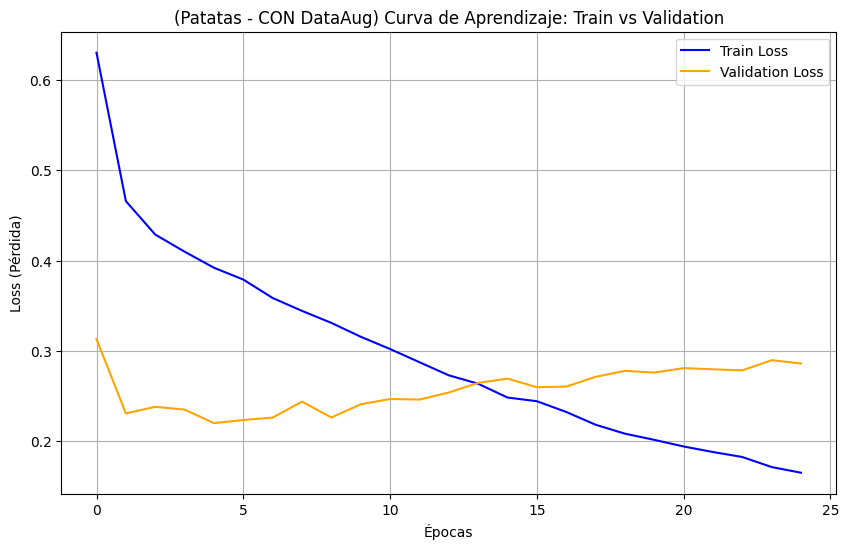

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Patatas - CON DataAug) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/test"
test_ann_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Patatas_DataAug = RoboflowCocoDataset(test_dir_Patatas_DataAug, test_ann_Patatas_DataAug)
test_loader_Patatas_DataAug = torch.utils.data.DataLoader(
    dataset_test_Patatas_DataAug,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["early bright", "healthy", "late bright"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN (Patatas - CON DataAug) ---")
metrics_train = evaluate_model(modelo_Patatas_DataAug, train_loader_Patatas_DataAug, device, class_names=mis_clases)

print("\n--- TEST (Patatas - CON DataAug) ---")
metrics_test = evaluate_model(modelo_Patatas_DataAug, test_loader_Patatas_DataAug, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

--- TRAIN (Patatas - CON DataAug) ---


Evaluando...: 100%|██████████| 115/115 [00:28<00:00,  3.98it/s]



Métricas Generales:
mAP (50-95): 0.8288
mAP (50):    0.9853
mAR (Recall):0.8670
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.7280
healthy        : 0.9324
late bright    : 0.8261


--- TEST (Patatas - CON DataAug) ---


Evaluando...: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]



Métricas Generales:
mAP (50-95): 0.4717
mAP (50):    0.6683
mAR (Recall):0.6329
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.3132
healthy        : 0.9249
late bright    : 0.1769



# 3. Dataset MANZANAS

https://universe.roboflow.com/gfsm/manzanas-d2h2w

## 3.1. Dataset MANZANAS (SIN DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/pruebasrcnn/manzanas-d2h2w-mzww1 en su versión "v1_NO_DataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v1 (v1_NO_DataAug - sin data augmentation)
project = rf.workspace("pruebasrcnn").project("manzanas-d2h2w-mzww1")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to manzanas-1 in coco:: 100%|██████████| 1640/1640 [00:00<00:00, 10749.06it/s]


In [ ]:
# Rutas a los datos descargados
train_dir_Manzanas = "/content/manzanas-1/train"
train_ann_Manzanas = "/content/manzanas-1/train/_annotations.coco.json"
valid_dir_Manzanas = "/content/manzanas-1/valid"
valid_ann_Manzanas = "/content/manzanas-1/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Manzanas = RoboflowCocoDataset(train_dir_Manzanas, train_ann_Manzanas)
dataset_valid_Manzanas = RoboflowCocoDataset(valid_dir_Manzanas, valid_ann_Manzanas)

train_loader_Manzanas = torch.utils.data.DataLoader(
    dataset_train_Manzanas,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Manzanas = torch.utils.data.DataLoader(
    dataset_valid_Manzanas,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Manzanas = dataset_train_Manzanas.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Manzanas = coco_Manzanas.getCatIds()
categories_Manzanas = coco_Manzanas.loadCats(cat_ids_Manzanas)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Manzanas)}")
print("-" * 30)
for cat in categories_Manzanas:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 5
------------------------------
ID: 0 - Nombre: enfermedades
ID: 1 - Nombre: Alternaria_Leaf_Spot
ID: 2 - Nombre: Brown_Spot
ID: 3 - Nombre: Gray_Spot
ID: 4 - Nombre: Rust
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Manzanas, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Manzanas, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 1147
Imágenes de validación: 242


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: NVIDIA A100-SXM4-80GB


In [ ]:
num_classes_Manzanas = 5
modelo_Manzanas = get_FasterRCNN_model(num_classes_Manzanas)
modelo_Manzanas.to(device);

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 246MB/s]


In [ ]:
params_Manzanas = [p for p in modelo_Manzanas.parameters() if p.requires_grad]
optimizer_Manzanas = torch.optim.SGD(params_Manzanas, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Manzanas) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Manzanas.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Manzanas, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Manzanas(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Manzanas.zero_grad()
        losses.backward()
        optimizer_Manzanas.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Manzanas:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Manzanas(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Manzanas.state_dict(), "best_model_Manzanas.pth")

print("(Manzanas) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Manzanas) Iniciando entrenamiento...


Época 1/25 [Train]: 100%|██████████| 72/72 [00:32<00:00,  2.22it/s, loss=0.281]


--> Fin Época 1 | Train Loss: 0.4112 | Valid Loss: 0.2995


Época 2/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.40it/s, loss=0.119]


--> Fin Época 2 | Train Loss: 0.2194 | Valid Loss: 0.2127


Época 3/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.194]


--> Fin Época 3 | Train Loss: 0.1712 | Valid Loss: 0.2007


Época 4/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.40it/s, loss=0.142]


--> Fin Época 4 | Train Loss: 0.1476 | Valid Loss: 0.1977


Época 5/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.121]


--> Fin Época 5 | Train Loss: 0.1332 | Valid Loss: 0.1824


Época 6/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.40it/s, loss=0.126]


--> Fin Época 6 | Train Loss: 0.1190 | Valid Loss: 0.1990


Época 7/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.137]


--> Fin Época 7 | Train Loss: 0.1116 | Valid Loss: 0.1966


Época 8/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0688]


--> Fin Época 8 | Train Loss: 0.1032 | Valid Loss: 0.2017


Época 9/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.059]


--> Fin Época 9 | Train Loss: 0.0981 | Valid Loss: 0.2076


Época 10/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.113]


--> Fin Época 10 | Train Loss: 0.0878 | Valid Loss: 0.2078


Época 11/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.40it/s, loss=0.0639]


--> Fin Época 11 | Train Loss: 0.0823 | Valid Loss: 0.2204


Época 12/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0663]


--> Fin Época 12 | Train Loss: 0.0785 | Valid Loss: 0.2162


Época 13/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.35it/s, loss=0.0745]


--> Fin Época 13 | Train Loss: 0.0738 | Valid Loss: 0.2247


Época 14/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.38it/s, loss=0.0419]


--> Fin Época 14 | Train Loss: 0.0683 | Valid Loss: 0.2238


Época 15/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.38it/s, loss=0.056]


--> Fin Época 15 | Train Loss: 0.0651 | Valid Loss: 0.2264


Época 16/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.38it/s, loss=0.0578]


--> Fin Época 16 | Train Loss: 0.0615 | Valid Loss: 0.2282


Época 17/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0745]


--> Fin Época 17 | Train Loss: 0.0553 | Valid Loss: 0.2264


Época 18/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.38it/s, loss=0.0709]


--> Fin Época 18 | Train Loss: 0.0554 | Valid Loss: 0.2341


Época 19/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0717]


--> Fin Época 19 | Train Loss: 0.0546 | Valid Loss: 0.2387


Época 20/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.38it/s, loss=0.0604]


--> Fin Época 20 | Train Loss: 0.0532 | Valid Loss: 0.2323


Época 21/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0237]


--> Fin Época 21 | Train Loss: 0.0465 | Valid Loss: 0.2418


Época 22/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0315]


--> Fin Época 22 | Train Loss: 0.0460 | Valid Loss: 0.2524


Época 23/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0386]


--> Fin Época 23 | Train Loss: 0.0442 | Valid Loss: 0.2390


Época 24/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0274]


--> Fin Época 24 | Train Loss: 0.0438 | Valid Loss: 0.2438


Época 25/25 [Train]: 100%|██████████| 72/72 [00:30<00:00,  2.39it/s, loss=0.0441]


--> Fin Época 25 | Train Loss: 0.0436 | Valid Loss: 0.2490
(Manzanas) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Manzanas): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Manzanas): 855.82 segundos
	Equivalente a: 14.26 minutos


### 3. Validación (sobre el conjunto de test)

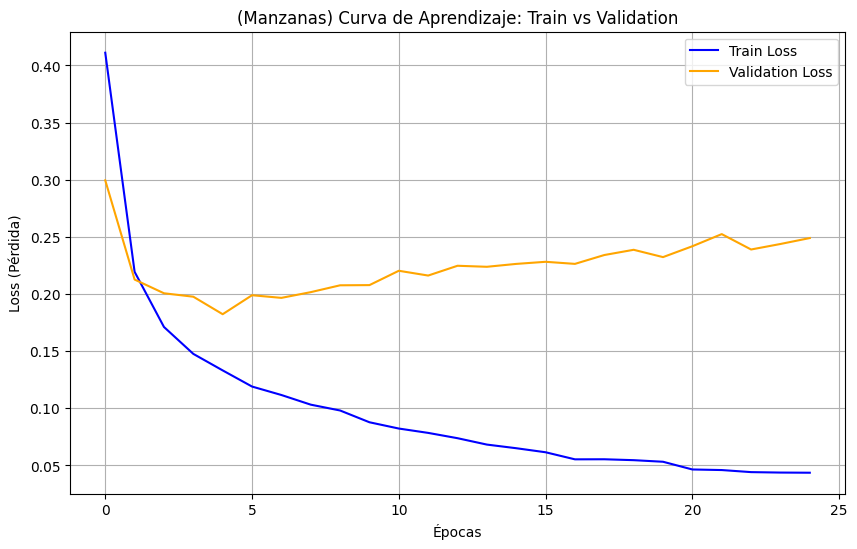

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Manzanas) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Manzanas = "/content/manzanas-1/test"
test_ann_Manzanas = "/content/manzanas-1/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Manzanas = RoboflowCocoDataset(test_dir_Manzanas, test_ann_Manzanas)
test_loader_Manzanas = torch.utils.data.DataLoader(
    dataset_test_Manzanas,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["Alternaria_Leaf_Spot", "Brown_Spot", "Gray_Spot", "Rust"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN ---")
metrics_train = evaluate_model(modelo_Manzanas, train_loader_Manzanas, device, class_names=mis_clases)

print("\n--- TEST ---")
metrics_test = evaluate_model(modelo_Manzanas, test_loader_Manzanas, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

--- TRAIN ---


Evaluando...: 100%|██████████| 72/72 [00:16<00:00,  4.35it/s]



Métricas Generales:
mAP (50-95): 0.8662
mAP (50):    0.9998
mAR (Recall):0.9044
----------------------------------------
Desglose por Clase (mAP 50-95):
Alternaria_Leaf_Spot: 0.8363
Brown_Spot     : 0.8803
Gray_Spot      : 0.8746
Rust           : 0.8737


--- TEST ---


Evaluando...: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]



Métricas Generales:
mAP (50-95): 0.4409
mAP (50):    0.7411
mAR (Recall):0.5642
----------------------------------------
Desglose por Clase (mAP 50-95):
Alternaria_Leaf_Spot: 0.4291
Brown_Spot     : 0.2982
Gray_Spot      : 0.3883
Rust           : 0.6481



## 3.2. Dataset MANZANAS (CON DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/pruebasrcnn/manzanas-d2h2w-mzww1 en su versión "v2_DataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión 2 (v2_DataAug - CON data augmentation)
project = rf.workspace("pruebasrcnn").project("manzanas-d2h2w-mzww1")
version = project.version(2)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to manzanas-2 in coco:: 100%|██████████| 3934/3934 [00:00<00:00, 10562.16it/s]


In [ ]:
# Rutas a los datos descargados
train_dir_Manzanas_DataAug = "/content/manzanas-2/train"
train_ann_Manzanas_DataAug = "/content/manzanas-2/train/_annotations.coco.json"
valid_dir_Manzanas_DataAug = "/content/manzanas-2/valid"
valid_ann_Manzanas_DataAug = "/content/manzanas-2/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Manzanas_DataAug = RoboflowCocoDataset(train_dir_Manzanas_DataAug, train_ann_Manzanas_DataAug)
dataset_valid_Manzanas_DataAug = RoboflowCocoDataset(valid_dir_Manzanas_DataAug, valid_ann_Manzanas_DataAug)

train_loader_Manzanas_DataAug = torch.utils.data.DataLoader(
    dataset_train_Manzanas_DataAug,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Manzanas_DataAug = torch.utils.data.DataLoader(
    dataset_valid_Manzanas_DataAug,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Manzanas_DataAug = dataset_train_Manzanas_DataAug.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Manzanas_DataAug = coco_Manzanas_DataAug.getCatIds()
categories_Manzanas_DataAug = coco_Manzanas_DataAug.loadCats(cat_ids_Manzanas_DataAug)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Manzanas_DataAug)}")
print("-" * 30)
for cat in categories_Manzanas_DataAug:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 5
------------------------------
ID: 0 - Nombre: enfermedades
ID: 1 - Nombre: Alternaria_Leaf_Spot
ID: 2 - Nombre: Brown_Spot
ID: 3 - Nombre: Gray_Spot
ID: 4 - Nombre: Rust
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Manzanas_DataAug, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Manzanas_DataAug, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 3441
Imágenes de validación: 242


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: NVIDIA A100-SXM4-80GB


In [ ]:
num_classes_Manzanas_DataAug = 5
modelo_Manzanas_DataAug = get_FasterRCNN_model(num_classes_Manzanas_DataAug)
modelo_Manzanas_DataAug.to(device);

In [ ]:
params_Manzanas_DataAug = [p for p in modelo_Manzanas_DataAug.parameters() if p.requires_grad]
optimizer_Manzanas_DataAug = torch.optim.SGD(params_Manzanas_DataAug, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Manzanas CON DataAug) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Manzanas_DataAug.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Manzanas_DataAug, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Manzanas_DataAug(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Manzanas_DataAug.zero_grad()
        losses.backward()
        optimizer_Manzanas_DataAug.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Manzanas_DataAug:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Manzanas_DataAug(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Manzanas_DataAug.state_dict(), "best_model_Manzanas_DataAug.pth")

print("(Manzanas CON DataAug) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Manzanas CON DataAug) Iniciando entrenamiento...


Época 1/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=0.856]


--> Fin Época 1 | Train Loss: 0.3071 | Valid Loss: 0.2307


Época 2/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.40it/s, loss=0.0972]


--> Fin Época 2 | Train Loss: 0.2172 | Valid Loss: 0.2073


Época 3/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.40it/s, loss=0.278]


--> Fin Época 3 | Train Loss: 0.2033 | Valid Loss: 0.2028


Época 4/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.40it/s, loss=0.0674]


--> Fin Época 4 | Train Loss: 0.1897 | Valid Loss: 0.2039


Época 5/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.40it/s, loss=0.105]


--> Fin Época 5 | Train Loss: 0.1778 | Valid Loss: 0.1937


Época 6/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.40it/s, loss=0.043]


--> Fin Época 6 | Train Loss: 0.1655 | Valid Loss: 0.2069


Época 7/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.39it/s, loss=0.0789]


--> Fin Época 7 | Train Loss: 0.1566 | Valid Loss: 0.2051


Época 8/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.39it/s, loss=0.0779]


--> Fin Época 8 | Train Loss: 0.1481 | Valid Loss: 0.1975


Época 9/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.40it/s, loss=0.173]


--> Fin Época 9 | Train Loss: 0.1406 | Valid Loss: 0.2198


Época 10/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.39it/s, loss=8.99e-6]


--> Fin Época 10 | Train Loss: 0.1335 | Valid Loss: 0.2128


Época 11/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.39it/s, loss=0.0024]


--> Fin Época 11 | Train Loss: 0.1221 | Valid Loss: 0.2062


Época 12/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.39it/s, loss=0.256]


--> Fin Época 12 | Train Loss: 0.1153 | Valid Loss: 0.2274


Época 13/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.39it/s, loss=0.0946]


--> Fin Época 13 | Train Loss: 0.1132 | Valid Loss: 0.2271


Época 14/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=0.185]


--> Fin Época 14 | Train Loss: 0.1044 | Valid Loss: 0.2305


Época 15/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.39it/s, loss=0.000358]


--> Fin Época 15 | Train Loss: 0.1006 | Valid Loss: 0.2352


Época 16/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=0.126]


--> Fin Época 16 | Train Loss: 0.0901 | Valid Loss: 0.2554


Época 17/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=2.12e-6]


--> Fin Época 17 | Train Loss: 0.0876 | Valid Loss: 0.2303


Época 18/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=0.0293]


--> Fin Época 18 | Train Loss: 0.0802 | Valid Loss: 0.2135


Época 19/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=1.93e-6]


--> Fin Época 19 | Train Loss: 0.0744 | Valid Loss: 0.2224


Época 20/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=0.0253]


--> Fin Época 20 | Train Loss: 0.0726 | Valid Loss: 0.2309


Época 21/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=5.66e-6]


--> Fin Época 21 | Train Loss: 0.0678 | Valid Loss: 0.2265


Época 22/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=0.124]


--> Fin Época 22 | Train Loss: 0.0655 | Valid Loss: 0.2260


Época 23/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.38it/s, loss=5.25e-5]


--> Fin Época 23 | Train Loss: 0.0638 | Valid Loss: 0.2291


Época 24/25 [Train]: 100%|██████████| 216/216 [01:31<00:00,  2.37it/s, loss=4.06e-6]


--> Fin Época 24 | Train Loss: 0.0586 | Valid Loss: 0.2301


Época 25/25 [Train]: 100%|██████████| 216/216 [01:30<00:00,  2.37it/s, loss=0.0158]


--> Fin Época 25 | Train Loss: 0.0608 | Valid Loss: 0.2468
(Manzanas CON DataAug) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Manzanas CON DataAug): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Manzanas CON DataAug): 2364.70 segundos
	Equivalente a: 39.41 minutos


### 3. Validación (sobre el conjunto de test)

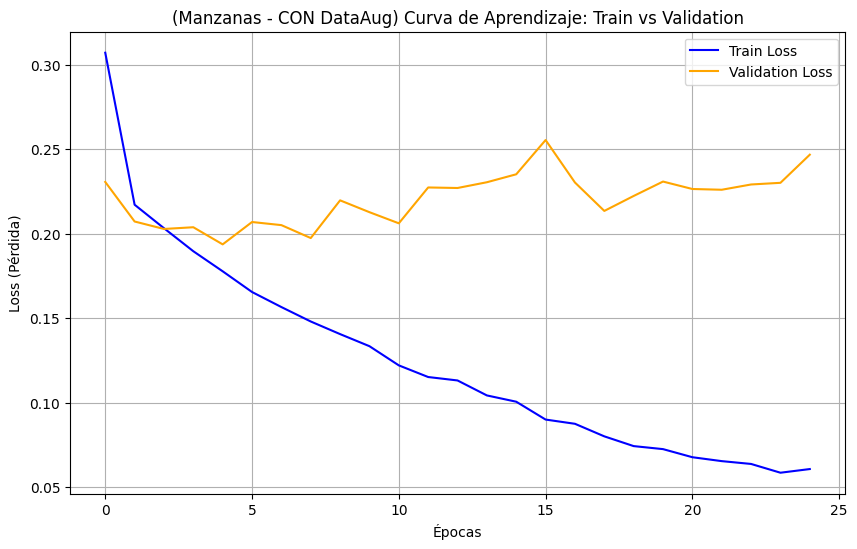

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Manzanas - CON DataAug) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Manzanas_DataAug = "/content/manzanas-2/test"
test_ann_Manzanas_DataAug = "/content/manzanas-2/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Manzanas_DataAug = RoboflowCocoDataset(test_dir_Manzanas_DataAug, test_ann_Manzanas_DataAug)
test_loader_Manzanas_DataAug = torch.utils.data.DataLoader(
    dataset_test_Manzanas_DataAug,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["Alternaria_Leaf_Spot", "Brown_Spot", "Gray_Spot", "Rust"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN (Manzanas CON DataAug) ---")
metrics_train = evaluate_model(modelo_Manzanas_DataAug, train_loader_Manzanas_DataAug, device, class_names=mis_clases)

print("\n--- TEST (Manzanas CON DataAug) ---")
metrics_test = evaluate_model(modelo_Manzanas_DataAug, test_loader_Manzanas_DataAug, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

--- TRAIN (Manzanas CON DataAug) ---


Evaluando...: 100%|██████████| 216/216 [00:49<00:00,  4.38it/s]



Métricas Generales:
mAP (50-95): 0.7999
mAP (50):    0.9945
mAR (Recall):0.8455
----------------------------------------
Desglose por Clase (mAP 50-95):
Alternaria_Leaf_Spot: 0.8071
Brown_Spot     : 0.8214
Gray_Spot      : 0.7604
Rust           : 0.8109


--- TEST (Manzanas CON DataAug) ---


Evaluando...: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]



Métricas Generales:
mAP (50-95): 0.3654
mAP (50):    0.7380
mAR (Recall):0.4933
----------------------------------------
Desglose por Clase (mAP 50-95):
Alternaria_Leaf_Spot: 0.3810
Brown_Spot     : 0.2424
Gray_Spot      : 0.3000
Rust           : 0.5382

